In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from copy import deepcopy
from helper_function import AgeFeatureExtract, OutlierClipping, datatype_converter

In [2]:
df = pd.read_csv('innercity.csv')
data = df.copy()
data.head()

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3034200666,20141107T000000,808100,4,3.25,3020,13457,1.0,0,0,...,0,1956,0,98133,47.7174,-122.336,2120,7553,1,16477
1,8731981640,20141204T000000,277500,4,2.50,2550,7500,1.0,0,0,...,800,1976,0,98023,47.3165,-122.386,2260,8800,0,10050
2,5104530220,20150420T000000,404000,3,2.50,2370,4324,2.0,0,0,...,0,2006,0,98038,47.3515,-121.999,2370,4348,0,6694
3,6145600285,20140529T000000,300000,2,1.00,820,3844,1.0,0,0,...,0,1916,0,98133,47.7049,-122.349,1520,3844,0,4664
4,8924100111,20150424T000000,699000,2,1.50,1400,4050,1.0,0,0,...,0,1954,0,98115,47.6768,-122.269,1900,5940,0,5450


In [3]:
data.shape

(21613, 23)

In [4]:
data.isnull().any().sum()

0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
cid                 21613 non-null int64
dayhours            21613 non-null object
price               21613 non-null int64
room_bed            21613 non-null int64
room_bath           21613 non-null float64
living_measure      21613 non-null int64
lot_measure         21613 non-null int64
ceil                21613 non-null float64
coast               21613 non-null int64
sight               21613 non-null int64
condition           21613 non-null int64
quality             21613 non-null int64
ceil_measure        21613 non-null int64
basement            21613 non-null int64
yr_built            21613 non-null int64
yr_renovated        21613 non-null int64
zipcode             21613 non-null int64
lat                 21613 non-null float64
long                21613 non-null float64
living_measure15    21613 non-null int64
lot_measure15       21613 non-null int64
furnished           2

* Extracting Age and renovated age of house from build, renovated and sold year.
* So now we can work with age columns and drop year column


In [6]:
sold_year = data['dayhours'].str.extract(r'(\d{4})', expand = False)
data['house_age'] = sold_year.astype('int64') - data['yr_built']
data['renovated_age'] = data.apply(lambda x: x['yr_renovated']-x['yr_built'] if x['yr_renovated'] != 0 else 0, axis = 1)

In [7]:
data.drop(['cid','dayhours', 'yr_built', 'yr_renovated', 'lat', 'long'], axis = 1, inplace = True)

In [8]:
data.iloc[:,:9].describe()

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430
std,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000


In [9]:
data.iloc[:,9:].describe()

,quality,ceil_measure,basement,zipcode,living_measure15,lot_measure15,furnished,total_area,house_age,renovated_age
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000
mean,7.656873,1788.390691,291.509045,98077.939805,1986.552492,12768.455652,0.196687,1.718687e+04,43.317818,2.380882
std,1.175459,828.090978,442.575043,53.505026,685.391304,27304.179631,0.397503,4.158908e+04,29.375493,12.359528
min,1.000000,290.000000,0.000000,98001.000000,399.000000,651.000000,0.000000,1.423000e+03,-1.000000,0.000000
25%,7.000000,1190.000000,0.000000,98033.000000,1490.000000,5100.000000,0.000000,7.035000e+03,18.000000,0.000000
50%,7.000000,1560.000000,0.000000,98065.000000,1840.000000,7620.000000,0.000000,9.575000e+03,40.000000,0.000000
75%,8.000000,2210.000000,560.000000,98118.000000,2360.000000,10083.000000,0.000000,1.300000e+04,63.000000,0.000000
max,13.000000,9410.000000,4820.000000,98199.000000,6210.000000,871200.000000,1.000000,1.652659e+06,115.000000,114.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
price               21613 non-null int64
room_bed            21613 non-null int64
room_bath           21613 non-null float64
living_measure      21613 non-null int64
lot_measure         21613 non-null int64
ceil                21613 non-null float64
coast               21613 non-null int64
sight               21613 non-null int64
condition           21613 non-null int64
quality             21613 non-null int64
ceil_measure        21613 non-null int64
basement            21613 non-null int64
zipcode             21613 non-null int64
living_measure15    21613 non-null int64
lot_measure15       21613 non-null int64
furnished           21613 non-null int64
total_area          21613 non-null int64
house_age           21613 non-null int64
renovated_age       21613 non-null int64
dtypes: float64(2), int64(17)
memory usage: 3.1 MB


In [11]:
#sns.pairplot(data)

##### Multi Colinearity
* Total Area and Lot Measure has very high correlation.
* Ceil measure and living measure also has high correlation.
* So we could remove one column amoung these highly correlated.

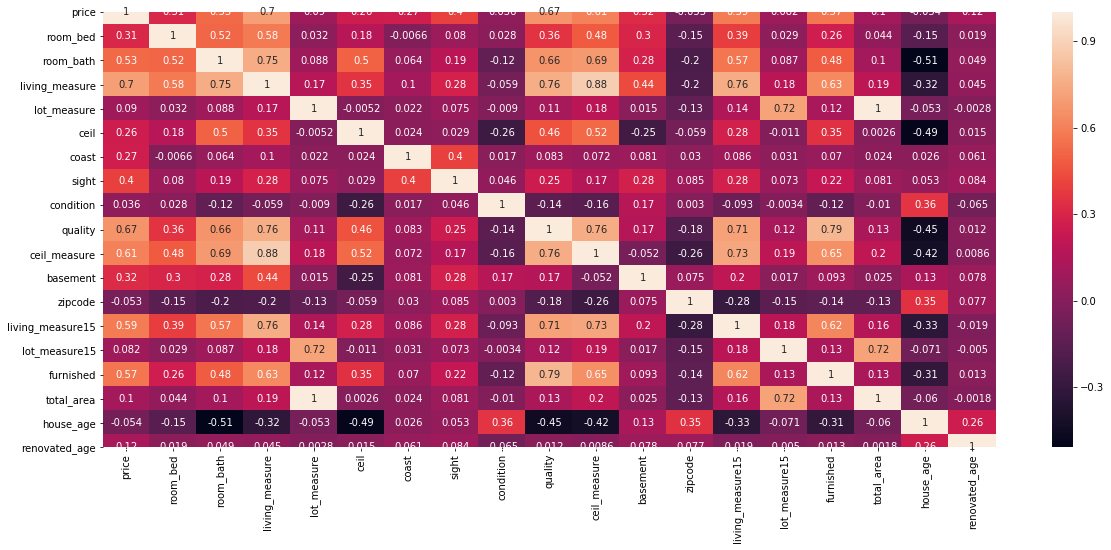

In [12]:
corr = data.corr()
fig, ax = plt.subplots(figsize=[20, 8])
sns.heatmap(corr, annot= True)

In [13]:
#For EDA purpose took the continuous area and descrete features seperately
discrete_features = ['room_bed', 'room_bath', 'ceil', 'coast', 'sight', 'condition', 'quality', 'furnished', 'house_age', 'renovated_age']
areas = ['living_measure','ceil_measure','basement','living_measure15', 'lot_measure15', 'total_area']

##### Univariate analysis
* Coast, Furnished took only binary values
* Condition, Quality, sight took only predefined values.
* So all the above features could be Onehot encoded
* Renovated Age has 2 meanings, value 0 means not renovated and non-Zero means renovated Age.

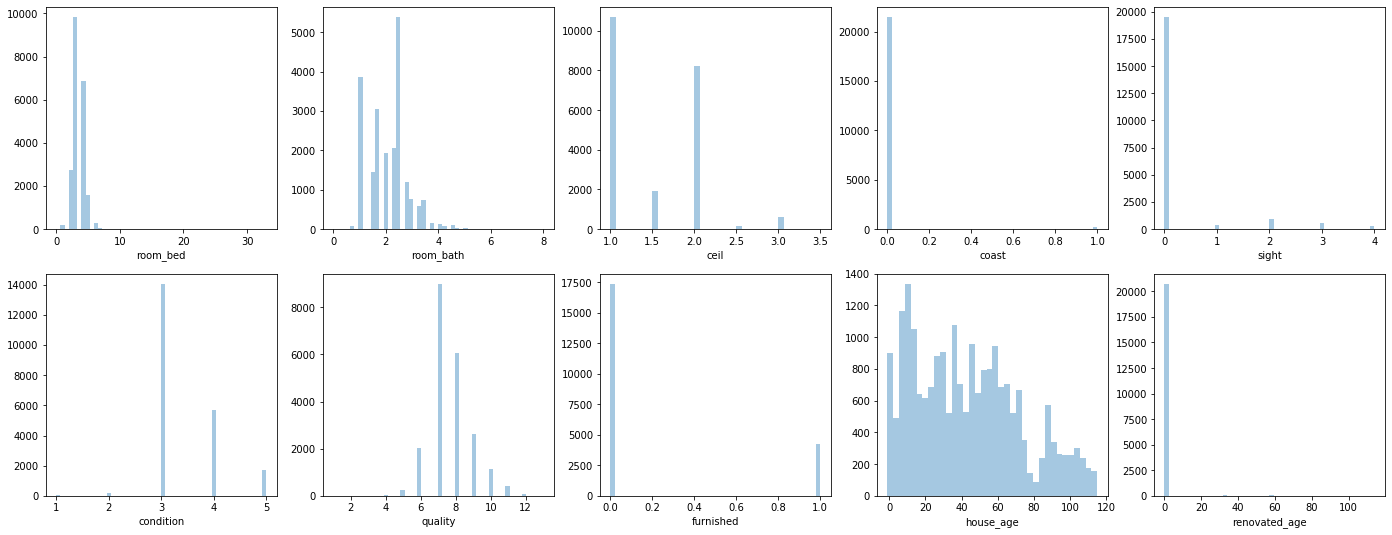

In [14]:
fig, axis = plt.subplots(nrows = 2, ncols = 5, figsize = [24, 9])

for ax, feature in zip(axis.flatten(), discrete_features):
  sns.distplot(data[feature], kde=False,ax=ax)

##### Renovated Age in Log Scale
* The house which are renovated follows normal distribution of ages.

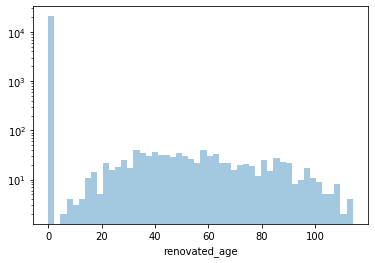

In [15]:
sns.distplot(data['renovated_age'], kde=False)
plt.yscale('log')

##### Discrete columms vs target feature

* As the Quality level increases the price increases, also furnished house are costly compared to unfurnished. So these 2 attributes will be better predictor.


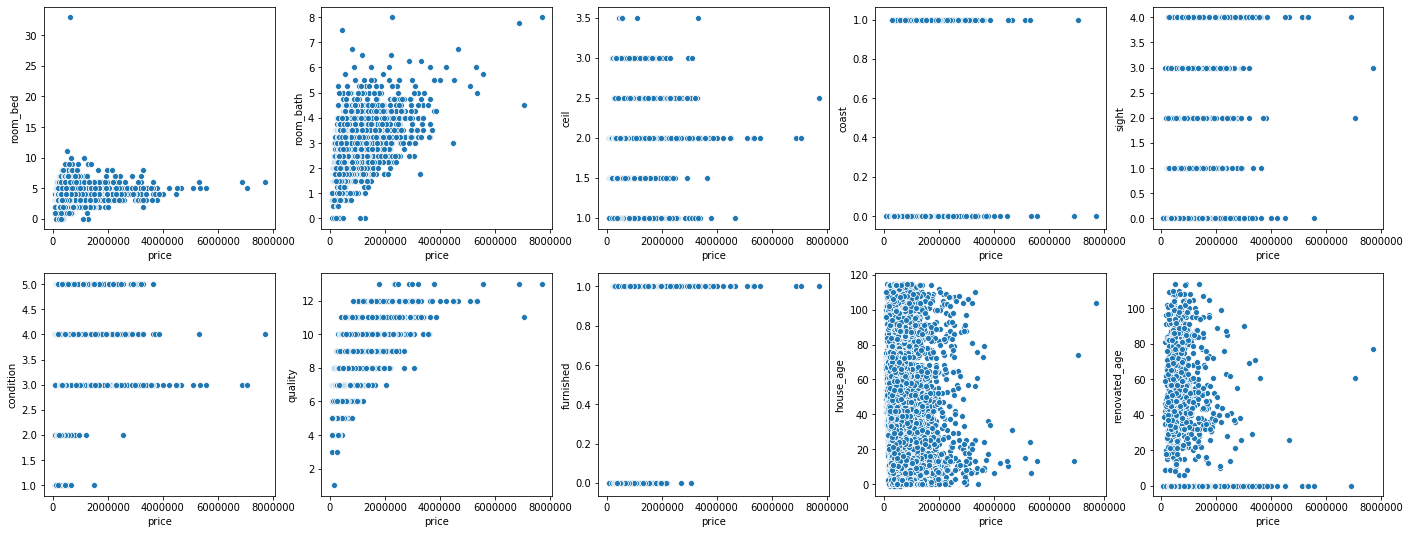

In [16]:
fig, axis = plt.subplots(nrows = 2, ncols = 5, figsize = [24, 9])

for ax, feature in zip(axis.flatten(), discrete_features):
  sns.scatterplot(x=data['price'],y=data[feature], ax=ax)

##### Univariate analysis of area features
* As like renovated Age here basement column has 2 meaning, value 0 means No basement and non-Zero means basement area.

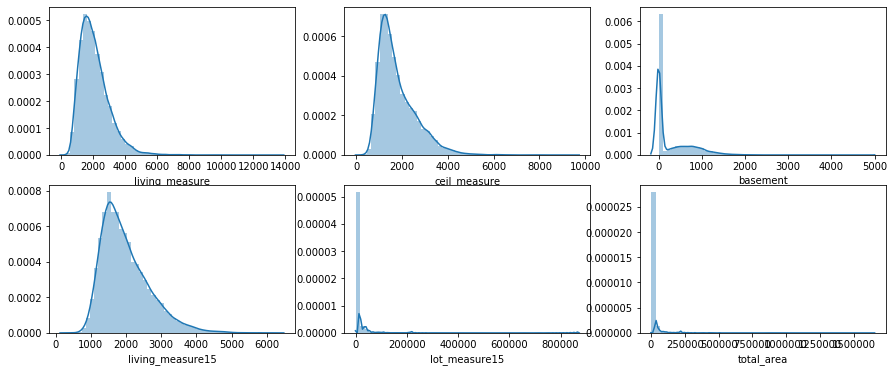

In [17]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = [15, 6])

for ax, feature in zip(axis.flatten(), areas):
  sns.distplot(data[feature], ax=ax)

##### Area features vs price of the house

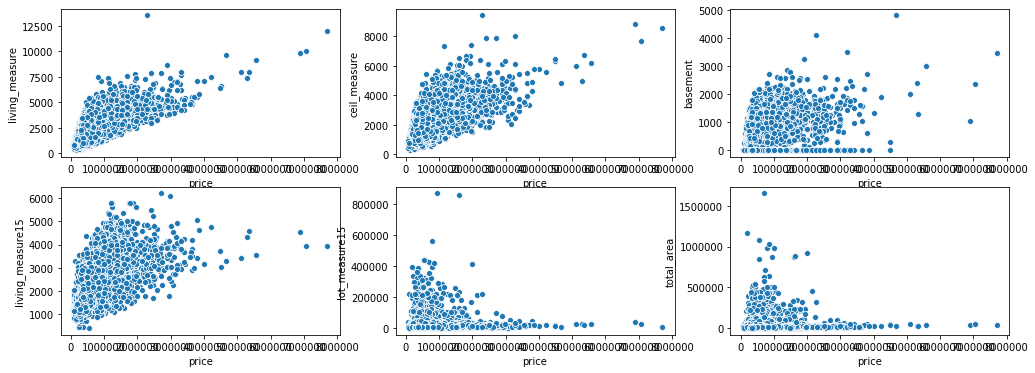

In [18]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = [17, 6])

for ax, feature in zip(axis.flatten(), areas):
  sns.scatterplot(x=data['price'], y=data[feature], ax=ax)

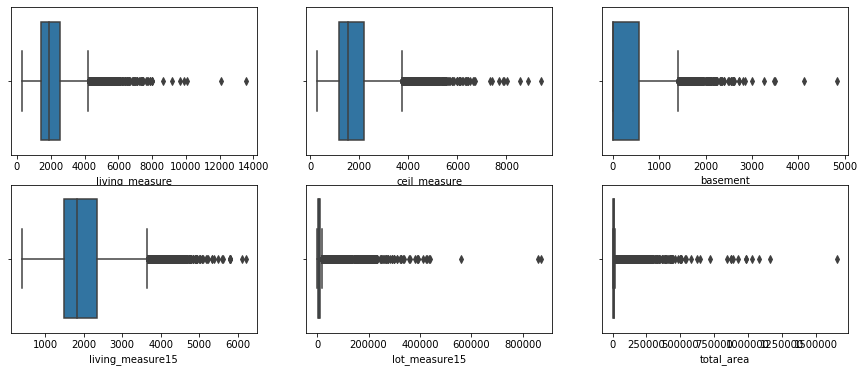

In [19]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = [15, 6])

for ax, feature in zip(axis.flatten(), areas):
  sns.boxplot(data[feature], ax=ax)

##### Zipcode vs Price of the house
* There is a huge variation in the average price of each zipcode areas. So zipcode will be a better predictor of price of house

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text xticklabel objects>)

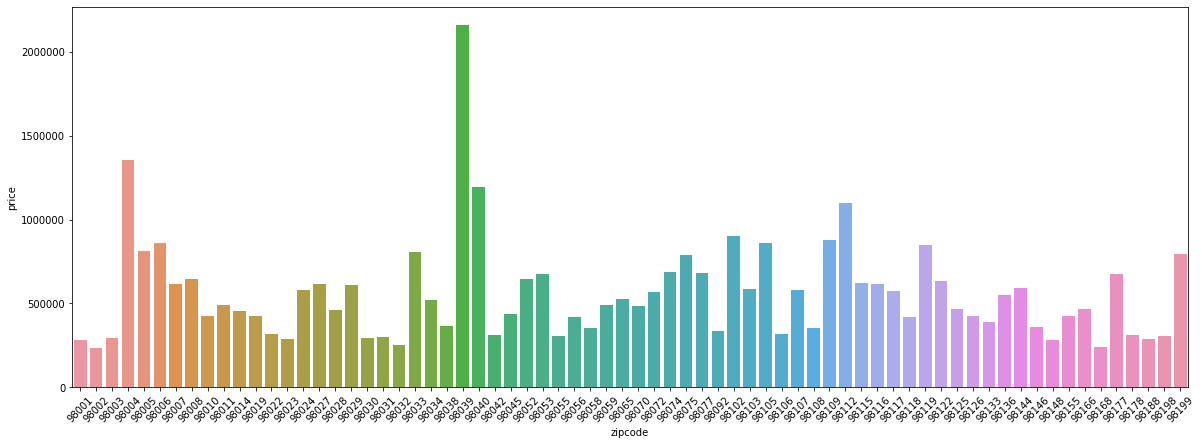

In [20]:
avg_price=data.groupby(['zipcode'])['price'].mean()
location=data.groupby(['zipcode'])['price'].mean().index
fig, ax = plt.subplots(figsize=[20,7])
sns.barplot(x=location,y=avg_price)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text xticklabel objects>)

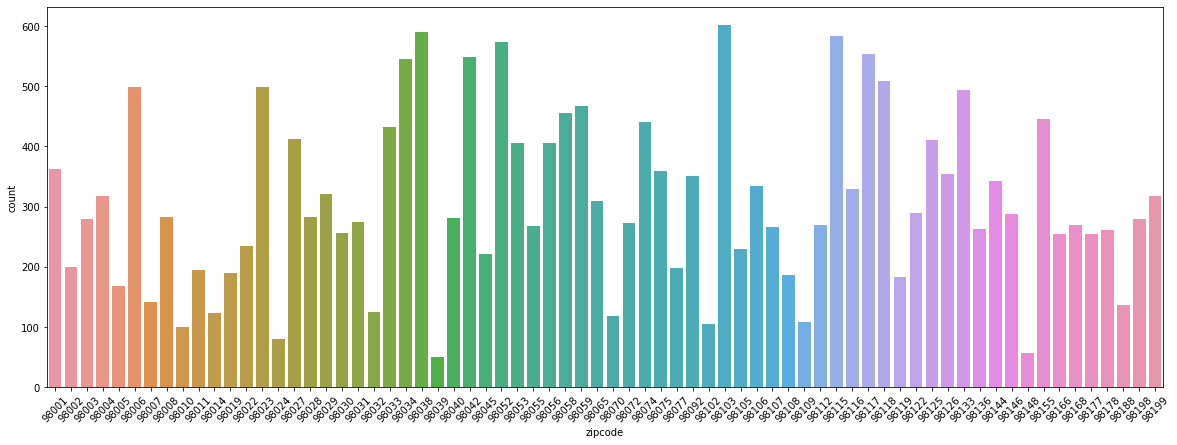

In [21]:
fig, ax = plt.subplots(figsize=[20,7])
sns.countplot(data['zipcode'])
plt.xticks(rotation=45)

In [22]:
data.head()

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,zipcode,living_measure15,lot_measure15,furnished,total_area,house_age,renovated_age
0,808100,4,3.25,3020,13457,1.0,0,0,5,9,3020,0,98133,2120,7553,1,16477,58,0
1,277500,4,2.50,2550,7500,1.0,0,0,3,8,1750,800,98023,2260,8800,0,10050,38,0
2,404000,3,2.50,2370,4324,2.0,0,0,3,8,2370,0,98038,2370,4348,0,6694,9,0
3,300000,2,1.00,820,3844,1.0,0,0,4,6,820,0,98133,1520,3844,0,4664,98,0
4,699000,2,1.50,1400,4050,1.0,0,0,4,8,1400,0,98115,1900,5940,0,5450,61,0


##### Preprocessing Steps
> * Create house age, renovated age from sold, build and renovated year.Then scalling it with MinMaxScaler.
> * Drop cid, dayhours, yr_built, yr_renovated, lat, long, lot_measure, ceil_measure.
> * Onehot encoding coast, sight, condition, quality, furnished, zipcode.





In [3]:
category_columns = ['coast', 'sight', 'condition', 'quality', 'furnished', 'zipcode']
numeric_columns = ['room_bed', 'room_bath', 'ceil', 'living_measure','basement','living_measure15', 'lot_measure15', 'total_area']

In [4]:
x = df.drop(['price', 'cid', 'lat', 'long', 'lot_measure', 'ceil_measure'], axis=1)
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=3)
x_train.head()

,dayhours,room_bed,room_bath,living_measure,ceil,coast,sight,condition,quality,basement,yr_built,yr_renovated,zipcode,living_measure15,lot_measure15,furnished,total_area
6573,20141211T000000,3,2.50,2000,3.0,0,0,3,8,0,2005,0,98109,1560,1340,0,3950
17792,20141017T000000,5,2.25,2500,1.0,0,0,3,7,650,1979,0,98072,2300,9750,0,16000
10661,20140505T000000,4,2.50,2800,1.0,0,0,3,8,1140,1963,0,98115,2580,5900,0,8700
297,20140917T000000,1,1.00,640,1.0,0,0,3,5,0,1939,0,98117,1270,6350,0,6990
16920,20141002T000000,3,2.50,1400,2.0,0,0,3,7,0,2013,0,98146,1400,4316,0,4768


* Creating a customer class to generate new age features

In [5]:

columns = ColumnTransformer(transformers=[
                                          ('numeric', MinMaxScaler(), numeric_columns),
                                          ('category', OneHotEncoder(handle_unknown ='ignore'), category_columns)
])
age = ColumnTransformer([
                         ('age', AgeFeatureExtract(), ['dayhours', 'yr_built', 'yr_renovated'])
])
age_pipe = make_pipeline(age,MinMaxScaler())

final_features = FeatureUnion([
                               ('ages', age_pipe),
                               ('features', columns)
])
pipelined_model = Pipeline(steps=[
                                  ('preprocessing', final_features),
                                  ('model', Lasso())
])

In [ ]:
from lightgbm import LGBMRegressor
models = [LinearRegression(), Lasso(), Ridge(), KNeighborsRegressor(),
          RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), LGBMRegressor()]
performance = pd.DataFrame(columns = ['Algorithm', 'Train R2 Score', 'Test R2 Score'])
fitted_models = []
for model in models:
  pipelined_model.set_params(model=model)
  pipelined_model.fit(x_train, y_train)
  fitted_models.append(deepcopy(pipelined_model))
  # print(str(model).split('(')[0])
  # print(pipelined_model.score(x_train, y_train))
  # print(pipelined_model.score(x_test, y_test))
  pipelined_model.fit(x_train, y_train)
  performance = performance.append({'Algorithm': str(model).split('(')[0],
                      'Train R2 Score': np.round(pipelined_model.score(x_train, y_train),2),
                      'Test R2 Score': np.round(pipelined_model.score(x_test, y_test),2)},  ignore_index=True 
                     )

In [ ]:
performance

In [6]:
numeric_columns_1 = ['room_bed', 'room_bath', 'ceil'] 
numeric_columns_2 = ['living_measure','basement','living_measure15', 'lot_measure15', 'total_area']

##### Clipping No of Bed room, no of bath rooms and ceil
* In the no of bed room, baoth rooms and ceil features, there is very rare no of occurence of value beyond certain limit.
* So we are cliping the upper limit of these feature which will also helps to remove the outliers.

In [ ]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = [20, 5])

for ax, feature in zip(axis.flatten(),  ['room_bed', 'room_bath', 'ceil', 'condition', 'quality'] ):
  #sns.distplot(data[feature], kde=False,ax=ax)
  sns.countplot(data[feature], ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  #ax.set_yscale('log')

In [ ]:
data.loc[:,'room_bed'] = data.loc[:,'room_bed'].clip(upper=6)
data.loc[:,'room_bath'] = data.loc[:,'room_bath'].clip(upper=3.75)
data.loc[:,'ceil'] = data.loc[:,'ceil'].clip(upper=2.5)
data.loc[:,'condition'] = data.loc[:,'condition'].clip(lower=2)
data.loc[:,'quality'] = data.loc[:,'quality'].clip(lower=5, upper=11)

fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = [20, 5])

for ax, feature in zip(axis.flatten(), ['room_bed', 'room_bath', 'ceil', 'condition', 'quality']):
  #sns.distplot(data[feature], kde=False,ax=ax)
  sns.countplot(data[feature], ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

##### Preprocessing Steps
> * Create house age, renovated age from sold, build and renovated year.Then scalling it with MinMaxScaler.
> * Drop cid, dayhours, yr_built, yr_renovated, lat, long, lot_measure, ceil_measure.
> * Onehotencoding coast, sight, condition, quality, furnished, zipcode.
> * Clipping the upper value of no of bed rooms, no of bath rooms and ceiling and onehotencoding it.

In [7]:
category_columns_v2 = ['coast', 'sight',  'furnished', 'zipcode']
numeric_columns_v2 = ['living_measure','basement','living_measure15', 'lot_measure15', 'total_area']

In [8]:
columns = ColumnTransformer(transformers=[
                                          ('numeric', MinMaxScaler(), numeric_columns_v2),
                                          ('category', OneHotEncoder(), category_columns_v2)
])
age = ColumnTransformer([
                         ('age', AgeFeatureExtract(), ['dayhours', 'yr_built', 'yr_renovated'])
])
age_pipe = make_pipeline(age,MinMaxScaler())
outlier_clip = ColumnTransformer([
                         ('clip', OutlierClipping(), ['room_bed', 'room_bath', 'ceil', 'condition', 'quality'] )
])
clip_pipe = make_pipeline(outlier_clip,OneHotEncoder())

final_features = FeatureUnion([
                               ('rooms', clip_pipe),
                               ('ages', age_pipe),
                               ('features', columns)
])
pipelined_model_v2 = Pipeline(steps=[
                                  ('preprocessing', final_features),
                                  ('model', XGBRegressor())
])

In [ ]:
models = [LinearRegression(), Lasso(), Ridge(), KNeighborsRegressor(),
           RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), LGBMRegressor()]
fitted_models = []
for model in models:
  pipelined_model_v2.set_params(model=model)
  pipelined_model_v2.fit(x_train, y_train)
  #fitted_models.append(deepcopy(pipelined_model_v2))
  # print(str(model).split('(')[0])
  # print(pipelined_model_v2.score(x_train, y_train))
  # print(pipelined_model_v2.score(x_test, y_test))
  performance = performance.append({'Algorithm': str(model).split('(')[0]+' with clipped features',
                      'Train R2 Score': np.round(pipelined_model_v2.score(x_train, y_train),2),
                      'Test R2 Score': np.round(pipelined_model_v2.score(x_test, y_test),2)},  ignore_index=True 
                     )

In [9]:
pipelined_model_v2.fit(x_train, y_train)
import pickle
filename = 'regressor.pkl'
pickle.dump(pipelined_model_v2, open(filename, 'wb'))

In [11]:
import xgboost
xgboost.__version__ 

'1.1.1'

In [ ]:
performance

In [ ]:
performance

##### Distribution of Area feature in Log Scale

In [ ]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = [15, 6])

for ax, feature in zip(axis.flatten(), areas):
  sns.distplot(data[feature], kde=False,ax=ax)
  ax.set_yscale('log')

In [ ]:
category_columns_v2 = ['coast', 'sight', 'condition', 'quality', 'furnished', 'zipcode']
numeric_columns_v3 = ['living_measure','living_measure15', 'lot_measure15', 'total_area']

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
columns = ColumnTransformer(transformers=[
                                          ('numeric', MinMaxScaler(), numeric_columns_v3),
                                          ('category', OneHotEncoder(), category_columns_v2)
])
age = ColumnTransformer([
                         ('age', AgeFeatureExtract(), ['dayhours', 'yr_built', 'yr_renovated'])
])
age_pipe = make_pipeline(age,MinMaxScaler())
outlier_clip = ColumnTransformer([
                         ('clip', OutlierClipping(), ['room_bed', 'room_bath', 'ceil'] )
])
clip_pipe = make_pipeline(outlier_clip,OneHotEncoder())

final_features = FeatureUnion([
                               ('rooms', clip_pipe),
                               ('ages', age_pipe),
                               ('features', columns)
])
pipelined_model_v3 = Pipeline(steps=[
                                  ('preprocessing', final_features),
                                  ('poly', PolynomialFeatures(interaction_only =True)),
                                  ('pca', TruncatedSVD (500)),
                                  ('model', Lasso())
])

In [ ]:
models = [LinearRegression(), Lasso(), Ridge(), KNeighborsRegressor(),
           RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor()]
fitted_models = []
for model in models:
  pipelined_model_v3.set_params(model=model)
  pipelined_model_v3.fit(x_train, y_train)
  # fitted_models.append(deepcopy(pipelined_model_v3))
  # print(str(model).split('(')[0])
  # print(pipelined_model_v3.score(x_train, y_train))
  # print(pipelined_model_v3.score(x_test, y_test))
  performance = performance.append({'Algorithm': str(model).split('(')[0]+' with Polyfeatures and Dimension reduction',
                      'Train R2 Score': np.round(pipelined_model_v3.score(x_train, y_train),2),
                      'Test R2 Score': np.round(pipelined_model_v3.score(x_test, y_test),2)},  ignore_index=True 
                     )

In [ ]:
performance

In [ ]:
columns = ColumnTransformer(transformers=[
                                          ('numeric', MinMaxScaler(), numeric_columns_v2),
                                          ('category', OneHotEncoder(), category_columns_v2)
])
age = ColumnTransformer([
                         ('age', AgeFeatureExtract(), ['dayhours', 'yr_built', 'yr_renovated'])
])
age_pipe = make_pipeline(age,MinMaxScaler())
outlier_clip = ColumnTransformer([
                         ('clip', OutlierClipping(), ['room_bed', 'room_bath', 'ceil'] )
])
clip_pipe = make_pipeline(outlier_clip,OneHotEncoder())

final_features = FeatureUnion([
                               ('rooms', clip_pipe),
                               ('ages', age_pipe),
                               ('features', columns)
])
pipelined_model_ann = Pipeline(steps=[
                                  ('preprocessing', final_features)])

In [ ]:
ann_train = pipelined_model_ann.fit_transform(x_train).todense()
ann_test = pipelined_model_ann.transform(x_test).todense()
ann_test

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
ann = Sequential()
ann.add(Dense(units = 256, activation = 'relu'))
ann.add(Dense(units = 128, activation = 'relu'))
ann.add(Dense(units = 64, activation = 'relu'))
ann.add(Dense(units = 1))
ann.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
ann.fit(x=ann_input, y=y_train, validation_data=(ann_test, y_test), epochs= 100)

In [ ]:
from sklearn.metrics import r2_score
ann_test_pred = ann.predict(ann_test)
r2_score(y_test, ann_test_pred)